This is the walkthrough of the book [Little Learner](https://www.amazon.com/Little-Learner-Straight-Line-Learning-ebook/dp/B0BCDKRPTJ).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

`l2_loss` calculates the loss of target given xs and corresponding ys.
`line` represents, well, a line `mx + b`.

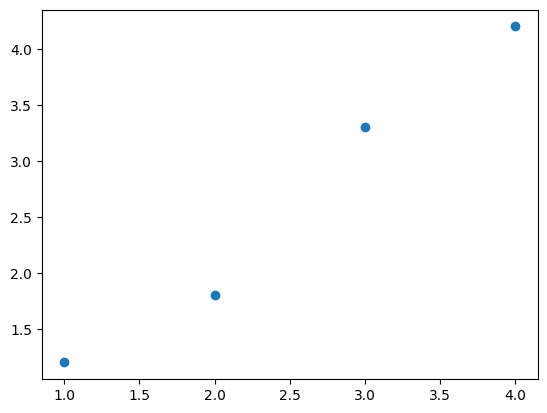

In [3]:
line_xs = np.array([2.0, 1.0, 4.0, 3.0])
line_ys =np.array([1.8, 1.2, 4.2, 3.3])
plt.scatter(line_xs, line_ys);

In [4]:
def l2_loss(target, xs: np.ndarray, ys: np.ndarray):
    def calculate_loss(params: np.ndarray) -> float:
        actual_ys = target(xs, params)
        return np.sum((actual_ys - ys) ** 2)

    return calculate_loss

def line(xs, params: np.ndarray):
    m, b = params
    return m * xs + b


l2_loss(line, xs=line_xs, ys=line_ys)(np.array([0, 0]))

33.21

We have a loss 33.21. That's pretty substantial. Let's improve that.

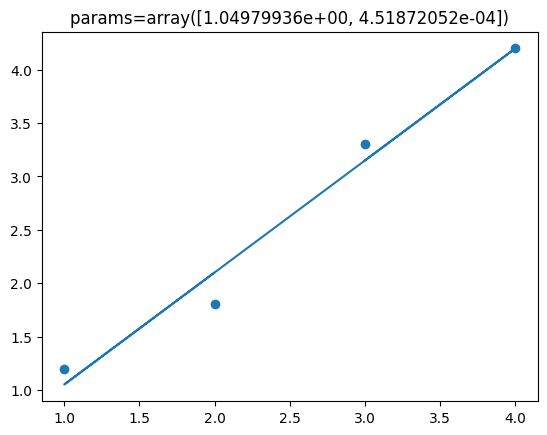

array([1.04979936e+00, 4.51872052e-04])

In [5]:
def learn(target, learning_rates, xs, ys, delta=0.0001, num_iterations=1000):
    # initial params
    params = np.array([0.0, 0.0])
    for i in range(num_iterations):
        loss = l2_loss(target, xs, ys)(params)
        change = np.array([0.0, 0.0])
        # we calculate partial derivatives and update each param
        # using learning_rate
        for j, value in enumerate(params):
            learning_params = params.copy()
            learning_params[j] += delta
            next_loss = l2_loss(target, xs, ys)(learning_params)
            # loss_rate is a gradient
            # we slide the gradient at each point to find the
            # better-fitted params
            loss_rate = (next_loss - loss) / delta
            change[j] -= loss_rate * learning_rates[j]
        params += change
    plt.scatter(line_xs, line_ys)
    plt.plot(line_xs, line(line_xs, params))
    plt.title(f'{params=}')
    plt.show()
    return params

learn(line, learning_rates=np.array([0.01, 0.01]), xs=line_xs, ys=line_ys)



Now the line is well-fitted.

In [6]:
def plane(xs, params: np.ndarray):
    # xs is a tensor of tensor_1 (xs=[[0, 0], [1, 1])
    # @ is a dot product
    return params[0] @ xs + params[1]

We can use `plane` in `learn`. Actually let's rename `learn` to `gradient_descent`, because that's what it is.

In [7]:
gradient_descent = learn

Let's extract calculation of partial derivatives to the separate function `gradient` and add `sample_size`

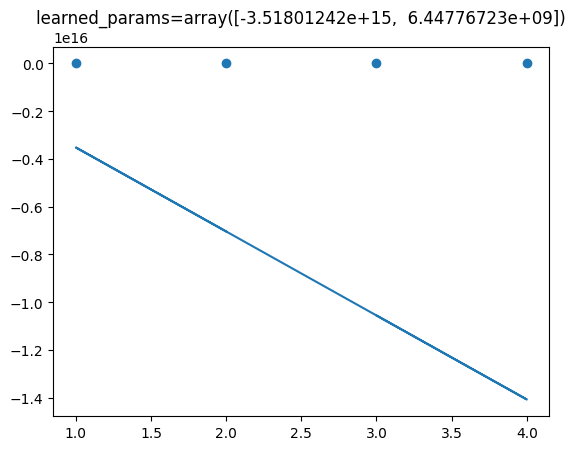

In [10]:
def l2_loss_gradient(target, xs, ys, params, delta=0.0001, sample_size=None):
    # TODO: rewrite it using numpy vector operations for efficiency
    # TODO: rewrite it using np.gradient
    gs = []
    if sample_size is None:
        indexes = np.arange(0, len(xs))
    else:
        indexes = np.random.randint(0, len(xs), sample_size)
        
    calc_loss = l2_loss(target, xs[indexes], ys[indexes])
    loss = calc_loss(params)
    for j, value in enumerate(params):
        learning_params = params.copy()
        learning_params[j] += delta
        next_loss = calc_loss(learning_params)
        # loss_rate is a gradient
        # we slide on the gradient at each point to find the
        # better-fitted params
        loss_rate = (next_loss - loss) / delta
        gs.append(loss_rate)
    return np.array(gs)


def gradient_descent(target, xs, ys, learning_rates, sample_size=None, delta=0.0001, num_iterations=1000):
    # initial params
    params = np.array([0.0, 0.0])
    for i in range(num_iterations):
        # we calculate partial derivatives and update each param
        # using learning_rate
        gs = l2_loss_gradient(target, xs, ys, params, sample_size=sample_size)
        params += -gs * learning_rates
    return params

        
def line_plot(xs, ys, learned_params):
    plt.scatter(xs, ys)
    plt.plot(xs, line(xs, learned_params))
    plt.title(f'{learned_params=}')
    plt.show()

learned_params = gradient_descent(line, np.arange(0, 100), np.arange(0, 100) * 1.5, sample_size=None, learning_rates=np.array([0.01, 0.01]))
line_plot(line_xs, line_ys, learned_params)
